In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256 #since the image has 256*256 pixels
BATCH_SIZE = 32 #32 is the stamdard size
CHANNELS = 3


### Data PIPELINING
- loading and filtering the data from the directory
- found 3 classes from the directory which is early,late,healthy and total 2152 images

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Datas/PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size =  BATCH_SIZE
        
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names # retrieving the class_names(y_train) from the dataset
class_names

['early_blight', 'healthy', 'late_blight']

In [6]:
len(dataset)

68

### Length of the dataset is 68 . Why
- #### the 68 is batch number
- and each batch contains 32 images exept for the last one
- 32*68 = 2176
- we have 2152 images meaning the last batch contains only 8 images


### Looping in the dataset returns image_data(x_train) and actual_image_label(y_train)

In [9]:
for image_batch,label_batch in dataset.take(1):
    print("Image batch first shape ",image_batch.shape)
    print("Image batch first ",image_batch[0][0][0])
    print("label_batch",label_batch.numpy())

Image batch first shape  (32, 256, 256, 3)
Image batch first  tf.Tensor([204. 179. 175.], shape=(3,), dtype=float32)
label_batch [2 0 0 2 2 0 2 2 0 2 2 0 1 2 0 0 0 2 1 0 2 0 2 0 2 2 0 0 2 0 2 0]


#### The shape contains (each_batch_number, x_pixel, y_pixel, RGB_channels)
- image_batch contains the actual data of the images in 3d array of RGB channels
- label_batch contains actual value(y_train) which can be converted in numpy
- #### 0=early_blight, 1 = healthy, 2 = late_blight

## IMAGE VISUALIZATION

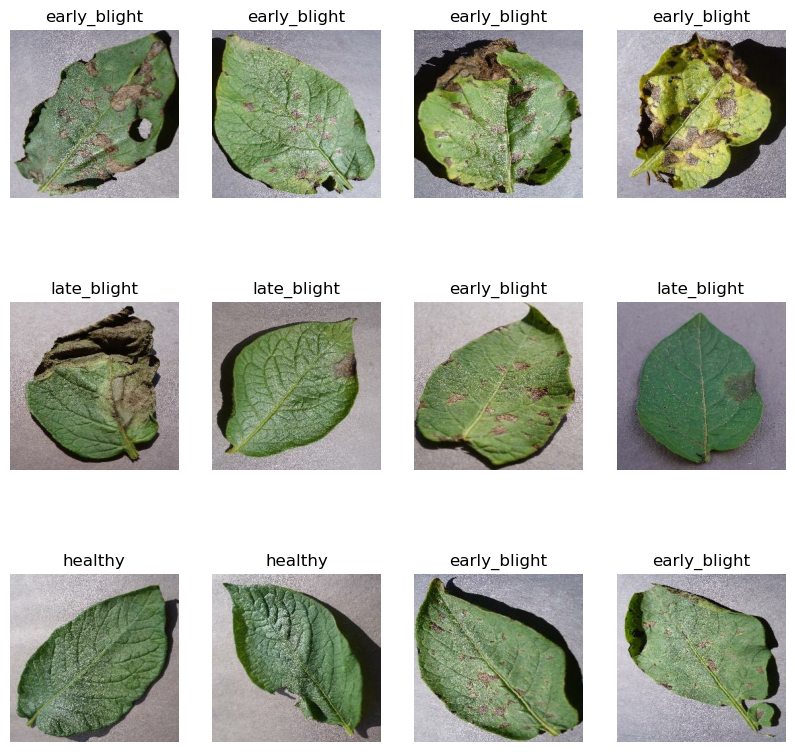

In [12]:
plt.figure(figsize=(10,10)) #increases the area of the plotting graph
for image_batch,label_batch in dataset.take(1): #looping through first batch containing multiple images upto 32
    for i in range(12):# taking 12 images from the first batch
        ax = plt.subplot(3,4,i+1) #plotting images into 3*4 matrix form
        plt.imshow(image_batch[i].numpy().astype("uint8")) #converting the image_data(which are int and floats into only int). and plotting it
        plt.title(class_names[label_batch[i]]) #setting title to the class name of the potato. label_batch gives integer and class_names gives names
        plt.axis("off")
    

### Train Test Split
- 80% for training data
- 20% for testing
- inside testing 10% is for validation and remaining 10% is for real_testing

In [14]:
train_size = 0.8 #
train_num = int(68*train_size)
train_num

54

In [15]:
#training dataset
train_ds = dataset.take(train_num)
len(train_ds)

54

### Splitted into validation and real test

In [17]:
#validation and testing dataset
test_ds = dataset.skip(train_num) #skippig 80% and taking remaining 20%
print(len(test_ds))
val_size = 0.1
val_num = int(68*val_size) #10% dataset for validation
print(val_num)
val_ds = test_ds.take(val_num) #taking six datasets for validation
print("Length of the validation dataset",len(val_ds))
real_test_ds = test_ds.skip(val_num)
print("real_test size",len(real_test_ds))#now taking remaining data from test_data as real_test_ds

14
6
Length of the validation dataset 6
real_test size 8


### Wrting above Hardcode into the Function

In [19]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [20]:
train_ds,val_ds,test_ds = get_dataset_partition_tf(dataset)

In [21]:
print(len(train_ds))
print()

54



### Prefetching and Caching the dataset for Optimized for training
-  prefetch helps in parellel processing of CPU(for reading) and GPU(for training)
-  cahcing helps to avoid going through the same loading and preprocessing steps again for each **epoch**

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Scaling and Resizing(Pre-Processing)
- scaling the RGB data maxupto 255 into the range of 0-1
- resizing the images into 256,256 pixel
- the trained image is already resized but we need this because it handles the image data if the pixel is not specified in the prediction insert
- we do it by using libraries

In [25]:
## Has been depriceiated this functions
# resize_and_rescale = tf.keras.Sequential([
#     #rescaling to 255 to 0-1
#     layers.experimental.preprocessing.Rescaling(1.0/255),

#     #resizing into 256,256
#     layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE)
    
# ])

In [26]:
from tensorflow.keras.layers import Rescaling, Resizing
resize_and_rescale = tf.keras.Sequential([
    Rescaling(1.0/255),
    Resizing(IMAGE_SIZE, IMAGE_SIZE)
])

### DATA_AGUMENTATION 
- is a trick to make training_images different each time without needing more data.
- So model just not only memorizw but to generalize.
- flips,moves,rotates,cobtrasts et5c
- the tensorflow changes the images a little bit live in every epoch

In [50]:
# data_augumentation = tf.keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     layers.experimental.preprocessing.Rotation(0.2)
# ])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

#### Created layers for preprocessing
- train test split
- loaded data into tensorflow dataset